# 1. Import modules

In [1]:
%load_ext autoreload

%autoreload 2
import time

import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import Link, Chain, ChainList

from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

from chainer import datasets, iterators, optimizers, serializers
from chainer import Function, report, training, utils, Variable

import numpy
import os
import glob
import sys
from pathlib import Path
import matplotlib.pyplot as plt

from chainer import Sequential
import easy_chainer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Define of structure
## MLP_01 : MLP, dropout=None, Batch_Normalization=None
## MLP_02 : MLP, Dropout, Batch_Normalization

In [106]:
class MLP_01(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP_01, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
            
           
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [2]:
# 4層NN(入力→中間，中間→出力)
class MLP_02(chainer.Chain):
    
    """
    モデルの実装
    """

    def __init__(self, n_units, n_out, train=True, drop_out_ratio=0.1):
        super(MLP_02, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
    
        # 学習の場合：True
        self.__train = train
        # drop outの実施有無
        self.__drop_out = True
        # drop outの比率
        self.drop_out_ratio = drop_out_ratio
    

    def __call__(self, x):
        drop_out = self.__train and self.__drop_out 
        h1 = F.dropout(F.relu(self.l1(x)), ratio=self.drop_out_ratio)
        h2 = F.dropout(F.relu(self.l2(h1)), ratio=self.drop_out_ratio)
        return self.l3(h2)
    
    
    # 学習の場合；True
    def __get_train(self):
        return self.__train
    
    def __set_train(self, train):
        self.__train = train
        
    train = property(__get_train, __set_train)
    
    # Dropoutを使用する場合：True
    def __get_drop_out(self):
        return self.__drop_out
    
    def __set_drop_out(self, drop_out):
        '''
        drop outフラグの設定
        '''
        self.__drop_out = drop_out
    
    drop_out = property(__get_drop_out, __set_drop_out)



In [3]:
# GPUの設定
def parse_device(args):
    gpu = None
    if args.gpu is not None:
        gpu = args.gpu
    elif re.match(r'(-|\+|)[0-9]+$', args.device):
        gpu = int(args.device)

    if gpu is not None:
        if gpu < 0:
            return chainer.get_device(numpy)
        else:
            import cupy
            return chainer.get_device((cupy, gpu))

    return chainer.get_device(args.device)

# 3. Import datasets

In [64]:

data, teach = easy_chainer.load_Data("/home/fiber_classifier/Desktop/blood_glucose_fulldata.xlsx")
data = data.astype(numpy.float32)
teach = teach
#print(teach)
print(teach.shape)

(427,)


In [4]:
data, teach = easy_chainer.load_Data("/home/fiber_classifier/Desktop/val/val_katayama35.xlsx")
data = data.astype(numpy.float32)
teach = teach
#print(teach)
print(teach.shape)
print(data.shape)

# 回帰させるときに必要（分類はint型）
teach = teach.astype(numpy.float32)

(373,)
(1000, 373)


In [58]:
# 回帰させるときに必要（分類はint型）
teach = teach.astype(numpy.float32)

In [38]:
id_all = numpy.arange(1, len(teach) + 1, 1).astype(numpy.int32) - 1
print(id_all.shape)

(427,)


In [47]:
numpy.random.seed(13)
id_train_T = numpy.random.choice(id_all, 300, replace=False) #重複なし
#print(id_train_T.dtyoe)

In [48]:
id_test = numpy.delete(id_all, id_train_T)
#print(id_test)

In [49]:
id_train = numpy.delete(id_all, id_test)
#print(id_train)

In [130]:
id_train_1 = teach[0:394]
id_test_1 = teach[394:427]

id_train = id_train_1.astype(numpy.int32)
id_test = id_test_1.astype(numpy.int32)

# teach = teach.astype(numpy.float32)

# print("id_train : ", id_train)
print("id_train : ", id_train.shape)
print("id_train_type : ", id_train.dtype)

# print("id_test : ", id_test)
print("id_test : ", id_test.shape)
print("id_test : ", id_test.dtype)

id_train :  (394,)
id_train_type :  int32
id_test :  (33,)
id_test :  int32


In [200]:
id_train

array([ 97,  87, 111,  89,  89, 140, 150, 134, 142, 145, 146, 145, 146,
       136, 143, 159, 133, 147, 158, 143, 146, 142, 139, 137, 138, 140,
       138, 146, 136, 135, 131, 122, 126, 134, 129,  98,  94,  96,  87,
        96,  94,  98, 102,  90,  84,  94,  90, 124, 137, 139, 141, 151,
       133, 144, 121, 134, 139, 136, 122, 116, 125, 109, 111, 112, 111,
       116, 105, 115, 117, 128, 139, 121, 145, 147, 156, 154, 179, 154,
       145, 152, 158, 158, 149, 149, 157, 160, 150, 154, 157, 160, 135,
       148, 138, 140, 133, 135, 124, 133, 134, 120, 114, 117,  91,  97,
        98,  98, 109, 109, 119, 117, 118, 132, 142, 153, 147, 148, 152,
       151, 135, 143, 135, 152, 149, 139, 135, 153, 132, 140, 139, 132,
       131, 117, 130, 122, 122, 120, 120,  90,  90,  96,  89,  89,  95,
        96,  87,  99,  86,  96,  88,  91, 101, 168, 158, 153, 145, 151,
       155, 145, 144, 156, 156, 151, 160, 136, 147, 141, 141, 138, 143,
       147, 127, 154, 131, 120, 121, 131, 128, 129, 132, 136, 11

In [20]:
# train, test データをExcelに保存するスクリプト
# このスクリプトを追加する

teach_train = teach[id_train]
df_teach = pandas.DataFrame(teach_train, columns=['train'])
df_idtrain = pandas.DataFrame(id_train, columns=['id_train'])
df_train = pandas.concat([df_idtrain, df_teach], axis=1)
# print(df_train)

teach_test = teach[id_test]
df_id_test = pandas.DataFrame(teach_test, columns=['test'])
df_idtest = pandas.DataFrame(id_test, columns=['id_test'])
df_test = pandas.concat([df_idtest, df_id_test], axis=1)
# print(df_test)

df = pandas.concat([df_train, df_test], axis=1)
#df.to_excel("C:/Users/Owner/Desktop/Normalized/blood_glucose_teach_20191030.xlsx")
# print(df)

# 4. Separate datas

In [8]:
n = 35
m = 373 - n

x_train, y_train = data[:, 0:m], teach[0:m]
x_test, y_test = data[:, m:373], teach[m:373]

In [9]:

print(y_train.shape, y_train[1])
print(y_test.shape, y_test[1])

(338,) 90.0
(35,) 87.0


In [10]:
y_train

array([100., 104., 108., 100., 161., 167., 146., 164., 169., 167., 170.,
       178., 186., 198., 188., 175., 188., 178., 186., 174., 178., 189.,
       156., 167., 168., 148., 135., 146., 137., 140., 151., 148., 142.,
       144.,  90.,  90.,  96.,  89.,  89.,  95.,  96.,  87.,  99.,  86.,
        96.,  88.,  91., 101., 168., 158., 153., 145., 151., 155., 145.,
       144., 156., 156., 151., 160., 136., 147., 141., 141., 138., 143.,
       147., 127., 154., 131., 120., 121., 131., 128., 129., 132., 136.,
       117., 121., 117., 120.,  88.,  95.,  99.,  98., 107., 113., 113.,
       131., 121., 116., 137., 122., 111., 146., 142.,  91.,  97.,  98.,
        98., 109., 109., 119., 117., 118., 132., 142., 153., 147., 148.,
       152., 151., 135., 143., 135., 152., 149., 139., 135., 153., 132.,
       140., 139., 132., 131., 117., 130., 122., 122., 120., 120.,  98.,
        94.,  96.,  87.,  96.,  94.,  98., 102.,  90.,  84.,  94.,  90.,
       124., 137., 139., 141., 151., 133., 144., 12

# 5. Generate of iterator

In [10]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1,1 ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, 1))

train_iter = chainer.iterators.SerialIterator(train, 10, repeat=True,  shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

# 6. Define of models
## 6.1 model determination 

In [11]:
net = MLP_02(1000,1)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun = F.r2_score)
model.compute_accuracy = False

gpu_id = 0
model.to_gpu()

## 6.2 define of optimizer

In [12]:
# 最適化方法
#optimizer = chainer.optimizers.SGD()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# 7. Trainer
## define of updater

In [13]:
# 学習回数（epoch）とかを決める
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (3000, 'epoch'), out="Result2019_oono/%s" % time.strftime("%Y%m%d%H%M%S"))
out_directory = "./Result2019_oono/%s" % time.strftime("%Y%m%d_%H%M%S")

## 7.2 Option determination

In [31]:
# オプションです

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


## 7.3 Start of training

In [32]:
trainer.run()

# モデル保存
net.to_cpu()

chainer.serializers.save_hdf5("/home/fiber_classifier/Desktop/model.hdf" ,obj=net)

numpy.save(arr=y_test, file="/home/fiber_classifier/Desktop/test_id.npy"  )
numpy.save(arr=y_train, file="/home/fiber_classifier/Desktop/train_id.npy" )


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           3340.66     2072.05                                                        0.118988      
2           1345.55     1073.83                                                        0.339842      
     total [..................................................]  0.10%
this epoch [###############################################...] 95.86%
       100 iter, 2 epoch / 3000 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
3           1221.5      653.465                                                        0.551101      
4           1138.62     612.354                                                        0.767178      
5           1009.96     426.028                                                        0.978399      
     total [..................................................]  0.20%
this epoch [#############################################.....] 91.72%
       200

     total [..................................................]  1.48%
this epoch [##################................................] 37.87%
      1500 iter, 44 epoch / 3000 epochs
    156.79 iters/sec. Estimated time to finish: 0:10:37.170974.
45          824.017     496.179                                                        9.54014       
46          810.332     464.981                                                        9.75054       
47          806.467     456.283                                                        9.96138       
     total [..................................................]  1.58%
this epoch [################..................................] 33.73%
      1600 iter, 47 epoch / 3000 epochs
    156.95 iters/sec. Estimated time to finish: 0:10:35.883109.
48          818.988     511.643                                                        10.1753       
49          748.052     456.155                                                        10.3871      

87          729.741     517.704                                                        18.6171       
88          739.692     491.434                                                        18.8298       
     total [#.................................................]  2.96%
this epoch [#####################################.............] 75.74%
      3000 iter, 88 epoch / 3000 epochs
    157.01 iters/sec. Estimated time to finish: 0:10:26.725583.
89          773.836     562.479                                                        19.0435       
90          725.927     517.369                                                        19.253        
91          749.957     532.79                                                         19.4651       
     total [#.................................................]  3.06%
this epoch [###################################...............] 71.60%
      3100 iter, 91 epoch / 3000 epochs
    157.05 iters/sec. Estimated time to finish: 0:10:25.913093

131         662.458     521.211                                                        28.1068       
132         670.342     613.435                                                        28.3243       
133         719.864     621.086                                                        28.5421       
     total [##................................................]  4.44%
this epoch [######............................................] 13.61%
      4500 iter, 133 epoch / 3000 epochs
    156.46 iters/sec. Estimated time to finish: 0:10:19.328849.
134         732.875     542.085                                                        28.7609       
135         742.993     568.214                                                        28.9785       
136         701.15      599.67                                                         29.1984       
     total [##................................................]  4.54%
this epoch [####..............................................]  9.47%

175         714.859     722.395                                                        37.8052       
176         684.774     774.065                                                        38.0266       
177         660.11      637.774                                                        38.2475       
     total [##................................................]  5.92%
this epoch [#########################.........................] 51.48%
      6000 iter, 177 epoch / 3000 epochs
    155.79 iters/sec. Estimated time to finish: 0:10:12.366160.
178         676.713     652.728                                                        38.4694       
179         682.743     710.782                                                        38.6911       
180         735.692     795.149                                                        38.908        
     total [###...............................................]  6.02%
this epoch [#######################...........................] 47.34%

219         655.78      655.801                                                        47.4862       
220         709.77      741.312                                                        47.6986       
221         675.676     717.136                                                        47.9151       
     total [###...............................................]  7.40%
this epoch [############################################......] 89.35%
      7500 iter, 221 epoch / 3000 epochs
    155.55 iters/sec. Estimated time to finish: 0:10:03.677582.
222         647.008     645.398                                                        48.1315       
223         648.772     697.763                                                        48.3463       
224         688.426     687.315                                                        48.5616       
     total [###...............................................]  7.50%
this epoch [##########################################........] 85.21%

     total [####..............................................]  8.78%
this epoch [###############...................................] 31.36%
      8900 iter, 263 epoch / 3000 epochs
    155.31 iters/sec. Estimated time to finish: 0:09:55.575832.
264         645.368     835.433                                                        57.2811       
265         651.863     788.889                                                        57.4974       
266         637.409     929.144                                                        57.7171       
     total [####..............................................]  8.88%
this epoch [#############.....................................] 27.22%
      9000 iter, 266 epoch / 3000 epochs
    155.28 iters/sec. Estimated time to finish: 0:09:55.038537.
267         679.076     825.373                                                        57.9385       
268         675.477     974.294                                                        58.1582    

306         633.175     940.662                                                        66.5541       
307         681.272     1007.35                                                        66.7758       
     total [#####.............................................] 10.26%
this epoch [##################################................] 69.23%
     10400 iter, 307 epoch / 3000 epochs
    154.95 iters/sec. Estimated time to finish: 0:09:47.279041.
308         634.334     793.234                                                        66.9994       
309         613.081     861.65                                                         67.2215       
310         613.144     854.431                                                        67.4397       
     total [#####.............................................] 10.36%
this epoch [################################..................] 65.09%
     10500 iter, 310 epoch / 3000 epochs
    154.86 iters/sec. Estimated time to finish: 0:09:46.9740

350         639.264     950.713                                                        76.3743       
351         604.599     988.258                                                        76.599        
352         568.092     872.384                                                        76.8242       
     total [#####.............................................] 11.74%
this epoch [###...............................................]  7.10%
     11900 iter, 352 epoch / 3000 epochs
    153.98 iters/sec. Estimated time to finish: 0:09:41.227878.
353         577.878     971.625                                                        77.0508       
354         591.758     870.247                                                        77.2761       
355         621.984     1034.05                                                        77.4981       
     total [#####.............................................] 11.83%
this epoch [#.................................................]  2.96%

394         622.919     1032.2                                                         86.3314       
395         544.015     958.059                                                        86.5562       
396         574.767     1027.54                                                        86.7832       
     total [######............................................] 13.21%
this epoch [######################............................] 44.97%
     13400 iter, 396 epoch / 3000 epochs
    152.89 iters/sec. Estimated time to finish: 0:09:35.567271.
397         580.972     1007.83                                                        87.0143       
398         588.997     954.465                                                        87.2429       
399         576.998     947.373                                                        87.4707       
     total [######............................................] 13.31%
this epoch [####################..............................] 40.83%

438         594.842     1047.28                                                        96.1851       
439         573.627     948.695                                                        96.409        
440         593.514     865.217                                                        96.628        
     total [#######...........................................] 14.69%
this epoch [#########################################.........] 82.84%
     14900 iter, 440 epoch / 3000 epochs
    152.31 iters/sec. Estimated time to finish: 0:09:27.918621.
441         616.838     1009.15                                                        96.8524       
442         621.323     962.149                                                        97.0728       
443         545.268     971.046                                                        97.2918       
     total [#######...........................................] 14.79%
this epoch [#######################################...........] 78.70%

     total [########..........................................] 16.07%
this epoch [############......................................] 24.85%
     16300 iter, 482 epoch / 3000 epochs
    152.35 iters/sec. Estimated time to finish: 0:09:18.572670.
483         556.543     1080.81                                                        106.11        
484         577.475     1064.71                                                        106.333       
485         611.257     1123.83                                                        106.553       
     total [########..........................................] 16.17%
this epoch [##########........................................] 20.71%
     16400 iter, 485 epoch / 3000 epochs
    152.34 iters/sec. Estimated time to finish: 0:09:17.955512.
486         560.159     1082.19                                                        106.777       
487         541.395     963.034                                                        107        

525         558.972     1091.2                                                         115.479       
526         518.995     1150.29                                                        115.702       
     total [########..........................................] 17.55%
this epoch [###############################...................] 62.72%
     17800 iter, 526 epoch / 3000 epochs
    151.88 iters/sec. Estimated time to finish: 0:09:10.441374.
527         534.088     1079.83                                                        115.926       
528         583.436     1108.58                                                        116.149       
529         583.115     996.246                                                        116.372       
     total [########..........................................] 17.65%
this epoch [#############################.....................] 58.58%
     17900 iter, 529 epoch / 3000 epochs
    151.83 iters/sec. Estimated time to finish: 0:09:09.9617

569         573.992     1312.49                                                        134.772       
570         555.148     1109.41                                                        134.993       
571         534.59      1130.72                                                        135.217       
     total [#########.........................................] 19.03%
this epoch [..................................................]  0.59%
     19300 iter, 571 epoch / 3000 epochs
    132.43 iters/sec. Estimated time to finish: 0:10:19.955713.
572         580.911     1312.36                                                        135.442       
573         567.558     958.679                                                        135.668       
     total [#########.........................................] 19.13%
this epoch [################################################..] 96.45%
     19400 iter, 573 epoch / 3000 epochs
     132.6 iters/sec. Estimated time to finish: 0:10:18.3874

613         533.605     1296.85                                                        144.713       
614         565.391     1175                                                           144.94        
615         536.289     1320.86                                                        145.165       
     total [##########........................................] 20.51%
this epoch [###################...............................] 38.46%
     20800 iter, 615 epoch / 3000 epochs
    132.08 iters/sec. Estimated time to finish: 0:10:10.232262.
616         524.613     1171.51                                                        145.393       
617         541.758     1212.15                                                        145.619       
618         504.764     1013.57                                                        145.845       
     total [##########........................................] 20.61%
this epoch [#################.................................] 34.32%

657         523.994     1099.32                                                        154.691       
658         517.165     1321.05                                                        154.918       
659         530.938     1107.02                                                        155.146       
     total [##########........................................] 21.99%
this epoch [######################################............] 76.33%
     22300 iter, 659 epoch / 3000 epochs
    131.89 iters/sec. Estimated time to finish: 0:09:59.733073.
660         570.974     1216.64                                                        155.371       
661         543.107     1236.71                                                        155.599       
662         555.573     911.79                                                         155.826       
     total [###########.......................................] 22.09%
this epoch [####################################..............] 72.19%

     total [###########.......................................] 23.37%
this epoch [#########.........................................] 18.34%
     23700 iter, 701 epoch / 3000 epochs
    130.02 iters/sec. Estimated time to finish: 0:09:57.621806.
702         568.128     1291.47                                                        165.996       
703         538.549     1167.1                                                         166.226       
704         525.999     1218.64                                                        166.456       
     total [###########.......................................] 23.47%
this epoch [#######...........................................] 14.20%
     23800 iter, 704 epoch / 3000 epochs
       130 iters/sec. Estimated time to finish: 0:09:56.901504.
705         550.45      1254.88                                                        166.684       
706         557.174     1065.55                                                        166.914    

744         533.893     1477.96                                                        175.687       
745         586.225     927.245                                                        175.917       
     total [############......................................] 24.85%
this epoch [############################......................] 56.21%
     25200 iter, 745 epoch / 3000 epochs
    129.35 iters/sec. Estimated time to finish: 0:09:49.088565.
746         548.721     1217.12                                                        176.152       
747         542.587     1358.04                                                        176.385       
748         567.446     1192.71                                                        176.618       
     total [############......................................] 24.95%
this epoch [##########################........................] 52.07%
     25300 iter, 748 epoch / 3000 epochs
    129.29 iters/sec. Estimated time to finish: 0:09:48.5774

787         515.206     1153.53                                                        185.757       
788         530.584     1092.18                                                        185.995       
789         532.912     1255.58                                                        186.229       
     total [#############.....................................] 26.33%
this epoch [###############################################...] 94.08%
     26700 iter, 789 epoch / 3000 epochs
     128.6 iters/sec. Estimated time to finish: 0:09:40.884755.
790         579.265     1051.76                                                        186.461       
791         538.768     1254.21                                                        186.695       
792         555.691     1338.52                                                        186.93        
     total [#############.....................................] 26.43%
this epoch [############################################......] 89.94%

     total [#############.....................................] 27.71%
this epoch [##################................................] 36.09%
     28100 iter, 831 epoch / 3000 epochs
    125.78 iters/sec. Estimated time to finish: 0:09:42.761712.
832         537.636     900.397                                                        197.45        
833         530.343     1472.04                                                        197.678       
834         575.702     934.301                                                        197.905       
     total [#############.....................................] 27.81%
this epoch [###############...................................] 31.95%
     28200 iter, 834 epoch / 3000 epochs
    142.75 iters/sec. Estimated time to finish: 0:08:32.767937.
835         545.73      937.378                                                        198.132       
836         507.579     1153.78                                                        198.36     

874         531.173     1236.11                                                        207.168       
875         584.864     980.04                                                         207.393       
     total [##############....................................] 29.19%
this epoch [####################################..............] 73.96%
     29600 iter, 875 epoch / 3000 epochs
    142.13 iters/sec. Estimated time to finish: 0:08:25.161099.
876         539.838     985.587                                                        207.623       
877         551.168     1437.72                                                        207.853       
878         565.949     1092.18                                                        208.081       
     total [##############....................................] 29.29%
this epoch [##################################................] 69.82%
     29700 iter, 878 epoch / 3000 epochs
    142.11 iters/sec. Estimated time to finish: 0:08:24.5228

918         521.226     1155.45                                                        217.306       
919         566.57      1108.66                                                        217.534       
920         505.293     1131.68                                                        217.762       
     total [###############...................................] 30.67%
this epoch [#####.............................................] 11.83%
     31100 iter, 920 epoch / 3000 epochs
    141.75 iters/sec. Estimated time to finish: 0:08:15.942892.
921         558.977     949.939                                                        217.994       
922         555.696     1246.28                                                        218.223       
923         534.518     830.34                                                         218.453       
     total [###############...................................] 30.77%
this epoch [###...............................................]  7.69%

962         530.001     1052.5                                                         227.408       
963         540.357     1093.1                                                         227.638       
964         524.168     1022.61                                                        227.868       
     total [################..................................] 32.15%
this epoch [########################..........................] 49.70%
     32600 iter, 964 epoch / 3000 epochs
    141.53 iters/sec. Estimated time to finish: 0:08:06.131182.
965         523.388     1199.31                                                        228.097       
966         560.99      681.585                                                        228.328       
967         555.13      1276.51                                                        228.558       
     total [################..................................] 32.25%
this epoch [######################............................] 45.56%

1006        591.681     719.906                                                        237.61        
1007        550.773     1060.42                                                        237.844       
1008        540.314     811.948                                                        238.075       
     total [################..................................] 33.63%
this epoch [###########################################.......] 87.57%
     34100 iter, 1008 epoch / 3000 epochs
     143.6 iters/sec. Estimated time to finish: 0:07:48.670503.
1009        495.099     1221                                                           238.309       
1010        525.646     877.879                                                        238.539       
1011        560.407     1099.29                                                        238.77        
     total [################..................................] 33.73%
this epoch [#########################################.........] 83.43

1050        539.821     1089.93                                                        249.391       
     total [#################.................................] 35.01%
this epoch [##############....................................] 29.59%
     35500 iter, 1050 epoch / 3000 epochs
    140.12 iters/sec. Estimated time to finish: 0:07:50.301160.
1051        518.751     852.788                                                        249.626       
1052        525.532     968.952                                                        249.859       
1053        553.094     925.594                                                        250.092       
     total [#################.................................] 35.11%
this epoch [############......................................] 25.44%
     35600 iter, 1053 epoch / 3000 epochs
    140.12 iters/sec. Estimated time to finish: 0:07:49.590114.
1054        506.126     1300.38                                                        250.329  

1092        543.752     687.745                                                        259.234       
1093        540.054     1209.53                                                        259.468       
1094        553.322     942.309                                                        259.701       
     total [##################................................] 36.49%
this epoch [#################################.................] 67.46%
     37000 iter, 1094 epoch / 3000 epochs
    140.16 iters/sec. Estimated time to finish: 0:07:39.487153.
1095        544.694     900.851                                                        259.935       
1096        506.1       1011.08                                                        260.17        
1097        527.659     1075.11                                                        260.403       
     total [##################................................] 36.59%
this epoch [###############################...................] 63.31

1136        497.224     782.359                                                        269.569       
     total [##################................................] 37.87%
this epoch [####..............................................]  9.47%
     38400 iter, 1136 epoch / 3000 epochs
    142.26 iters/sec. Estimated time to finish: 0:07:22.860072.
1137        582.017     914.184                                                        269.805       
1138        487.971     713.755                                                        270.041       
1139        538.949     859.972                                                        270.278       
     total [##################................................] 37.97%
this epoch [##................................................]  5.33%
     38500 iter, 1139 epoch / 3000 epochs
    142.39 iters/sec. Estimated time to finish: 0:07:21.747643.
1140        555.825     872.77                                                         270.512  

1178        519.835     920.978                                                        279.596       
1179        517.101     841.152                                                        279.836       
1180        518.55      939.758                                                        280.071       
     total [###################...............................] 39.35%
this epoch [#######################...........................] 47.34%
     39900 iter, 1180 epoch / 3000 epochs
    141.61 iters/sec. Estimated time to finish: 0:07:14.295018.
1181        491.506     840.347                                                        280.312       
1182        487.875     896.948                                                        280.55        
1183        510.842     933.128                                                        280.79        
     total [###################...............................] 39.45%
this epoch [#####################.............................] 43.20

     total [####################..............................] 40.73%
this epoch [############################################......] 89.35%
     41300 iter, 1221 epoch / 3000 epochs
    141.12 iters/sec. Estimated time to finish: 0:07:05.870769.
1222        527.854     643.437                                                        290.139       
1223        489.543     771.7                                                          290.378       
1224        525.741     915.745                                                        290.617       
     total [####################..............................] 40.83%
this epoch [##########################################........] 85.21%
     41400 iter, 1224 epoch / 3000 epochs
    140.82 iters/sec. Estimated time to finish: 0:07:06.082260.
1225        507.898     627.877                                                        290.855       
1226        511.621     760.917                                                        291.095  

1264        521.211     883.206                                                        300.223       
1265        508.769     925.275                                                        300.46        
1266        498.147     613.59                                                         300.699       
     total [#####################.............................] 42.21%
this epoch [#############.....................................] 27.22%
     42800 iter, 1266 epoch / 3000 epochs
    139.97 iters/sec. Estimated time to finish: 0:06:58.658706.
1267        528.779     727.939                                                        300.941       
1268        512.124     937.964                                                        301.179       
1269        519.365     879.449                                                        301.419       
     total [#####################.............................] 42.31%
this epoch [###########.......................................] 23.08

     total [#####################.............................] 43.59%
this epoch [##################################................] 69.23%
     44200 iter, 1307 epoch / 3000 epochs
    135.84 iters/sec. Estimated time to finish: 0:07:01.086302.
1308        504.806     764.419                                                        312.641       
1309        527.279     618.562                                                        312.882       
1310        525.377     783.949                                                        313.123       
     total [#####################.............................] 43.69%
this epoch [################################..................] 65.09%
     44300 iter, 1310 epoch / 3000 epochs
     135.8 iters/sec. Estimated time to finish: 0:07:00.483996.
1311        484.57      621.486                                                        313.365       
1312        494.034     641.895                                                        313.604  

1350        548.353     513.802                                                        322.832       
1351        508.553     555.639                                                        323.078       
1352        505.691     619.05                                                         323.321       
     total [######################............................] 45.07%
this epoch [###...............................................]  7.10%
     45700 iter, 1352 epoch / 3000 epochs
    137.89 iters/sec. Estimated time to finish: 0:06:43.934452.
1353        509.523     707.267                                                        323.566       
1354        539.981     713.05                                                         323.809       
1355        520.996     665.411                                                        324.05        
     total [######################............................] 45.17%
this epoch [#.................................................]  2.96

     total [#######################...........................] 46.45%
this epoch [########################..........................] 49.11%
     47100 iter, 1393 epoch / 3000 epochs
    137.12 iters/sec. Estimated time to finish: 0:06:36.007406.
1394        560.514     637.497                                                        333.586       
1395        513.342     612.371                                                        333.828       
1396        510.094     428.106                                                        334.073       
     total [#######################...........................] 46.55%
this epoch [######################............................] 44.97%
     47200 iter, 1396 epoch / 3000 epochs
    137.06 iters/sec. Estimated time to finish: 0:06:35.440926.
1397        522.963     824.125                                                        334.319       
1398        536.66      585.416                                                        334.566  

1436        516.398     656.158                                                        343.888       
1437        479.884     467.427                                                        344.134       
     total [#######################...........................] 47.93%
this epoch [###########################################.......] 86.98%
     48600 iter, 1437 epoch / 3000 epochs
    136.52 iters/sec. Estimated time to finish: 0:06:26.750107.
1438        490.105     601.787                                                        344.38        
1439        502.917     670.258                                                        344.625       
1440        508.826     569.888                                                        344.867       
     total [########################..........................] 48.03%
this epoch [#########################################.........] 82.84%
     48700 iter, 1440 epoch / 3000 epochs
    136.24 iters/sec. Estimated time to finish: 0:06:26.81

1480        539.766     493.092                                                        354.707       
1481        479.139     725.388                                                        354.954       
1482        502.259     512.112                                                        355.202       
     total [########################..........................] 49.41%
this epoch [############......................................] 24.85%
     50100 iter, 1482 epoch / 3000 epochs
    135.71 iters/sec. Estimated time to finish: 0:06:18.014782.
1483        520.605     468.982                                                        355.452       
1484        503.396     633.199                                                        355.699       
1485        501.716     613.445                                                        355.943       
     total [########################..........................] 49.51%
this epoch [##########........................................] 20.71

     total [#########################.........................] 50.79%
this epoch [#################################.................] 66.86%
     51500 iter, 1523 epoch / 3000 epochs
    135.17 iters/sec. Estimated time to finish: 0:06:09.173708.
1524        514.438     573.869                                                        365.573       
1525        530.663     584.471                                                        365.819       
1526        552.569     697.925                                                        366.068       
     total [#########################.........................] 50.89%
this epoch [###############################...................] 62.72%
     51600 iter, 1526 epoch / 3000 epochs
    135.11 iters/sec. Estimated time to finish: 0:06:08.579986.
1527        512.372     352.687                                                        366.318       
1528        515.568     620.787                                                        366.568  

1566        521.586     510.231                                                        376.069       
1567        540.611     569.698                                                        376.32        
1568        500.364     657.763                                                        376.57        
     total [##########################........................] 52.27%
this epoch [##................................................]  4.73%
     53000 iter, 1568 epoch / 3000 epochs
    134.36 iters/sec. Estimated time to finish: 0:06:00.234075.
1569        520.457     548.26                                                         376.823       
1570        564.878     445.182                                                        377.07        
1571        524.631     643.846                                                        377.321       
     total [##########################........................] 52.37%
this epoch [..................................................]  0.59

     total [##########################........................] 53.65%
this epoch [#######################...........................] 46.75%
     54400 iter, 1609 epoch / 3000 epochs
    132.88 iters/sec. Estimated time to finish: 0:05:53.690779.
1610        478.999     498.55                                                         389.351       
1611        505.649     474.242                                                        389.602       
1612        475.81      516.201                                                        389.852       
     total [##########################........................] 53.75%
this epoch [#####################.............................] 42.60%
     54500 iter, 1612 epoch / 3000 epochs
    132.84 iters/sec. Estimated time to finish: 0:05:53.062594.
1613        477.784     482.279                                                        390.105       
1614        568.706     800.735                                                        390.356  

1652        494.586     241.19                                                         399.839       
1653        575.261     560.864                                                        400.085       
     total [###########################.......................] 55.13%
this epoch [##########################################........] 84.62%
     55900 iter, 1653 epoch / 3000 epochs
    132.39 iters/sec. Estimated time to finish: 0:05:43.688925.
1654        540.868     638.023                                                        400.335       
1655        506.337     459.197                                                        400.578       
1656        535.99      550.263                                                        400.825       
     total [###########################.......................] 55.23%
this epoch [########################################..........] 80.47%
     56000 iter, 1656 epoch / 3000 epochs
    132.38 iters/sec. Estimated time to finish: 0:05:42.95

1696        491.706     411.692                                                        410.746       
1697        528.984     689.806                                                        410.995       
1698        456.085     553.043                                                        411.244       
     total [############################......................] 56.61%
this epoch [###########.......................................] 22.49%
     57400 iter, 1698 epoch / 3000 epochs
    132.13 iters/sec. Estimated time to finish: 0:05:32.994356.
1699        494.783     519.03                                                         411.494       
1700        510.729     426.816                                                        411.741       
1701        506.852     677.547                                                        411.992       
     total [############################......................] 56.71%
this epoch [#########.........................................] 18.34

     total [############################......................] 57.99%
this epoch [################################..................] 64.50%
     58800 iter, 1739 epoch / 3000 epochs
    131.89 iters/sec. Estimated time to finish: 0:05:23.003887.
1740        554.285     660.956                                                        421.684       
1741        526.588     367.279                                                        421.935       
1742        533.595     436.312                                                        422.184       
     total [#############################.....................] 58.09%
this epoch [##############################....................] 60.36%
     58900 iter, 1742 epoch / 3000 epochs
    131.87 iters/sec. Estimated time to finish: 0:05:22.292754.
1743        492.739     526.099                                                        422.434       
1744        497.297     471.053                                                        422.683  

1782        460.202     420.65                                                         432.159       
1783        508.661     508.5                                                          432.409       
1784        483.778     456.165                                                        432.659       
     total [#############################.....................] 59.47%
this epoch [#.................................................]  2.37%
     60300 iter, 1784 epoch / 3000 epochs
    131.63 iters/sec. Estimated time to finish: 0:05:12.227592.
1785        534.893     541.538                                                        432.907       
1786        487.138     340.081                                                        433.157       
     total [#############################.....................] 59.57%
this epoch [#################################################.] 98.22%
     60400 iter, 1786 epoch / 3000 epochs
    131.86 iters/sec. Estimated time to finish: 0:05:10.94

     total [##############################....................] 60.85%
this epoch [######################............................] 44.38%
     61700 iter, 1825 epoch / 3000 epochs
    131.42 iters/sec. Estimated time to finish: 0:05:02.083649.
1826        514.544     420.965                                                        443.172       
1827        502.621     632.835                                                        443.423       
1828        479.056     366.551                                                        443.673       
     total [##############################....................] 60.95%
this epoch [####################..............................] 40.24%
     61800 iter, 1828 epoch / 3000 epochs
    131.42 iters/sec. Estimated time to finish: 0:05:01.334338.
1829        517.704     551.357                                                        443.925       
1830        479.099     372.969                                                        444.173  

1868        518.495     416.753                                                        453.707       
1869        515.913     448.194                                                        453.958       
     total [###############################...................] 62.33%
this epoch [#########################################.........] 82.25%
     63200 iter, 1869 epoch / 3000 epochs
    131.37 iters/sec. Estimated time to finish: 0:04:50.778490.
1870        492.289     351.701                                                        454.207       
1871        502.1       458.309                                                        454.458       
1872        491.575     379.582                                                        454.71        
     total [###############################...................] 62.43%
this epoch [#######################################...........] 78.11%
     63300 iter, 1872 epoch / 3000 epochs
    135.41 iters/sec. Estimated time to finish: 0:04:41.37

1912        518.908     424.646                                                        464.827       
1913        494.14      496.082                                                        465.083       
1914        475.81      385.766                                                        465.34        
     total [###############################...................] 63.81%
this epoch [##########........................................] 20.12%
     64700 iter, 1914 epoch / 3000 epochs
    135.19 iters/sec. Estimated time to finish: 0:04:31.478080.
1915        498.267     422.44                                                         465.596       
1916        499.705     427.019                                                        465.85        
1917        512.787     353.819                                                        466.106       
     total [###############################...................] 63.91%
this epoch [#######...........................................] 15.98

     total [################################..................] 65.19%
this epoch [###############################...................] 62.13%
     66100 iter, 1955 epoch / 3000 epochs
    129.73 iters/sec. Estimated time to finish: 0:04:32.107265.
1956        447.178     385.786                                                        478.905       
1957        489.384     476.857                                                        479.166       
1958        523.205     304.629                                                        479.425       
     total [################################..................] 65.29%
this epoch [############################......................] 57.99%
     66200 iter, 1958 epoch / 3000 epochs
    129.66 iters/sec. Estimated time to finish: 0:04:31.487994.
1959        511.748     432.596                                                        479.685       
1960        499.985     285.272                                                        479.936  

1998        525.738     248.855                                                        489.721       
1999        515.638     517.951                                                        489.978       
2000        508.956     341.304                                                        490.233       
     total [#################################.................] 66.67%
this epoch [..................................................]  0.00%
     67600 iter, 2000 epoch / 3000 epochs
    129.06 iters/sec. Estimated time to finish: 0:04:21.899545.
2001        498.584     307.179                                                        490.489       
2002        487.878     454.646                                                        490.745       
     total [#################################.................] 66.77%
this epoch [###############################################...] 95.86%
     67700 iter, 2002 epoch / 3000 epochs
    129.27 iters/sec. Estimated time to finish: 0:04:20.70

     total [##################################................] 68.05%
this epoch [#####################.............................] 42.01%
     69000 iter, 2041 epoch / 3000 epochs
     128.5 iters/sec. Estimated time to finish: 0:04:12.144208.
2042        499.952     516.14                                                         501.018       
2043        491.449     272.307                                                        501.277       
2044        513.816     431.184                                                        501.536       
     total [##################################................] 68.15%
this epoch [##################................................] 37.87%
     69100 iter, 2044 epoch / 3000 epochs
    128.45 iters/sec. Estimated time to finish: 0:04:11.457766.
2045        566.545     481.694                                                        501.794       
2046        496.058     284.226                                                        502.05   

2084        607.019     292.532                                                        511.517       
2085        537.778     522.351                                                        511.762       
     total [##################################................] 69.53%
this epoch [#######################################...........] 79.88%
     70500 iter, 2085 epoch / 3000 epochs
    128.46 iters/sec. Estimated time to finish: 0:04:00.532794.
2086        498.968     213.153                                                        512.013       
2087        555.164     392.625                                                        512.262       
2088        480.568     391.514                                                        512.51        
     total [##################################................] 69.63%
this epoch [#####################################.............] 75.74%
     70600 iter, 2088 epoch / 3000 epochs
    128.47 iters/sec. Estimated time to finish: 0:03:59.74

2128        504.58      456.84                                                         522.496       
2129        518.516     203.757                                                        522.749       
2130        521.561     483.49                                                         522.996       
     total [###################################...............] 71.01%
this epoch [########..........................................] 17.75%
     72000 iter, 2130 epoch / 3000 epochs
    128.53 iters/sec. Estimated time to finish: 0:03:48.743781.
2131        518.71      436.902                                                        523.248       
2132        469.662     294.002                                                        523.498       
2133        561.487     577.073                                                        523.746       
     total [###################################...............] 71.10%
this epoch [######............................................] 13.61

     total [####################################..............] 72.39%
this epoch [#############################.....................] 59.76%
     73400 iter, 2171 epoch / 3000 epochs
     128.7 iters/sec. Estimated time to finish: 0:03:37.557128.
2172        530.158     416.106                                                        533.429       
2173        488.489     540.008                                                        533.68        
2174        485.243     230.531                                                        533.928       
     total [####################################..............] 72.49%
this epoch [###########################.......................] 55.62%
     73500 iter, 2174 epoch / 3000 epochs
    128.72 iters/sec. Estimated time to finish: 0:03:36.756383.
2175        568.166     239.123                                                        534.174       
2176        590.821     483.218                                                        534.424  

2214        493.49      456.594                                                        544.003       
2215        487.47      208.651                                                        544.25        
     total [####################################..............] 73.87%
this epoch [################################################..] 97.63%
     74900 iter, 2215 epoch / 3000 epochs
    129.09 iters/sec. Estimated time to finish: 0:03:25.285969.
2216        523.337     227.533                                                        544.505       
2217        568.762     374.703                                                        544.76        
2218        496.893     393.333                                                        545.016       
     total [####################################..............] 73.96%
this epoch [##############################################....] 93.49%
     75000 iter, 2218 epoch / 3000 epochs
    129.09 iters/sec. Estimated time to finish: 0:03:24.50

     total [#####################################.............] 75.25%
this epoch [###################...............................] 39.64%
     76300 iter, 2257 epoch / 3000 epochs
    133.97 iters/sec. Estimated time to finish: 0:03:07.360137.
2258        502.536     332.316                                                        555.112       
2259        451.924     381.645                                                        555.364       
2260        510.291     377.948                                                        555.612       
     total [#####################################.............] 75.35%
this epoch [#################.................................] 35.50%
     76400 iter, 2260 epoch / 3000 epochs
       134 iters/sec. Estimated time to finish: 0:03:06.572011.
2261        504.308     246.876                                                        555.864       
2262        485.241     408.146                                                        556.119  

2300        473.082     345.52                                                         565.739       
2301        479.206     283.602                                                        565.993       
     total [######################################............] 76.73%
this epoch [######################################............] 77.51%
     77800 iter, 2301 epoch / 3000 epochs
    134.31 iters/sec. Estimated time to finish: 0:02:55.713120.
2302        486.526     363.074                                                        566.248       
2303        445.904     377.044                                                        566.499       
2304        460.422     281.311                                                        566.755       
     total [######################################............] 76.82%
this epoch [####################################..............] 73.37%
     77900 iter, 2304 epoch / 3000 epochs
    134.32 iters/sec. Estimated time to finish: 0:02:54.95

2344        469.344     264.902                                                        576.883       
2345        497.606     317.538                                                        577.135       
2346        502.535     230.9                                                          577.391       
     total [#######################################...........] 78.21%
this epoch [#######...........................................] 15.38%
     79300 iter, 2346 epoch / 3000 epochs
    134.53 iters/sec. Estimated time to finish: 0:02:44.271335.
2347        518.432     415.442                                                        577.647       
2348        478.341     250.486                                                        577.902       
2349        481.071     307.49                                                         578.158       
     total [#######################################...........] 78.30%
this epoch [#####.............................................] 11.24

     total [#######################################...........] 79.59%
this epoch [############################......................] 57.40%
     80700 iter, 2387 epoch / 3000 epochs
    134.16 iters/sec. Estimated time to finish: 0:02:34.296202.
2388        493.674     307.992                                                        588.063       
2389        480.481     299.796                                                        588.32        
2390        508.209     298.799                                                        588.573       
     total [#######################################...........] 79.68%
this epoch [##########################........................] 53.25%
     80800 iter, 2390 epoch / 3000 epochs
    134.13 iters/sec. Estimated time to finish: 0:02:33.584961.
2391        479.829     294.345                                                        588.83        
2392        503.477     207.024                                                        589.085  

2430        493.955     228.218                                                        602.288       
2431        454.136     234.341                                                        602.547       
     total [########################################..........] 81.07%
this epoch [###############################################...] 95.27%
     82200 iter, 2431 epoch / 3000 epochs
    127.95 iters/sec. Estimated time to finish: 0:02:30.058586.
2432        555.059     349.674                                                        602.804       
2433        511.634     266.434                                                        603.062       
2434        482.676     366.001                                                        603.321       
     total [########################################..........] 81.16%
this epoch [#############################################.....] 91.12%
     82300 iter, 2434 epoch / 3000 epochs
     127.9 iters/sec. Estimated time to finish: 0:02:29.33

2474        513.905     341.702                                                        613.648       
2475        489.542     214.45                                                         613.903       
2476        468.132     341.687                                                        614.161       
     total [#########################################.........] 82.54%
this epoch [################..................................] 33.14%
     83700 iter, 2476 epoch / 3000 epochs
    127.01 iters/sec. Estimated time to finish: 0:02:19.362288.
2477        529.128     321.532                                                        614.428       
2478        451.554     288.323                                                        614.688       
2479        460.634     308.647                                                        614.948       
     total [#########################################.........] 82.64%
this epoch [##############....................................] 28.99

     total [#########################################.........] 83.93%
this epoch [#####################################.............] 75.15%
     85100 iter, 2517 epoch / 3000 epochs
    126.46 iters/sec. Estimated time to finish: 0:02:08.898222.
2518        452.614     255.017                                                        625.12        
2519        466.744     233.05                                                         625.38        
2520        511.806     218.703                                                        625.637       
     total [##########################################........] 84.02%
this epoch [###################################...............] 71.01%
     85200 iter, 2520 epoch / 3000 epochs
    126.41 iters/sec. Estimated time to finish: 0:02:08.152845.
2521        463.672     184.642                                                        625.9         
2522        516.405     244.045                                                        626.162  

2560        464.172     254.036                                                        636.05        
2561        482.087     283.852                                                        636.314       
2562        540.855     251.352                                                        636.576       
     total [##########################################........] 85.40%
this epoch [######............................................] 13.02%
     86600 iter, 2562 epoch / 3000 epochs
    125.88 iters/sec. Estimated time to finish: 0:01:57.570668.
2563        497.687     209.741                                                        636.837       
2564        527.233     232.432                                                        637.099       
2565        529.531     252.809                                                        637.357       
     total [##########################################........] 85.50%
this epoch [####..............................................]  8.88

     total [###########################################.......] 86.79%
this epoch [###########################.......................] 55.03%
     88000 iter, 2603 epoch / 3000 epochs
    125.32 iters/sec. Estimated time to finish: 0:01:46.923692.
2604        550.007     162.295                                                        647.574       
2605        526.89      231.05                                                         647.833       
2606        484.661     179.689                                                        648.096       
     total [###########################################.......] 86.88%
this epoch [#########################.........................] 50.89%
     88100 iter, 2606 epoch / 3000 epochs
    125.28 iters/sec. Estimated time to finish: 0:01:46.166096.
2607        543.035     255.971                                                        648.363       
2608        500.287     215.449                                                        648.625  

2646        520.358     342.542                                                        658.651       
2647        480.895     194.67                                                         658.916       
     total [############################################......] 88.26%
this epoch [##############################################....] 92.90%
     89500 iter, 2647 epoch / 3000 epochs
    124.85 iters/sec. Estimated time to finish: 0:01:35.314399.
2648        528.812     292.867                                                        659.182       
2649        517.504     277.173                                                        659.446       
2650        521.645     168.521                                                        659.705       
     total [############################################......] 88.36%
this epoch [############################################......] 88.76%
     89600 iter, 2650 epoch / 3000 epochs
     124.8 iters/sec. Estimated time to finish: 0:01:34.55

2690        552.215     174.118                                                        670.307       
2691        477.659     227.888                                                        670.572       
2692        527.545     170.617                                                        670.837       
     total [############################################......] 89.74%
this epoch [###############...................................] 30.77%
     91000 iter, 2692 epoch / 3000 epochs
    123.89 iters/sec. Estimated time to finish: 0:01:23.948770.
2693        551.136     273.758                                                        671.103       
2694        537.603     198.68                                                         671.366       
2695        512.611     395.287                                                        671.625       
     total [############################################......] 89.84%
this epoch [#############.....................................] 26.63

     total [#############################################.....] 91.12%
this epoch [####################################..............] 72.78%
     92400 iter, 2733 epoch / 3000 epochs
    128.82 iters/sec. Estimated time to finish: 0:01:09.866856.
2734        509.874     239.859                                                        681.996       
2735        501.467     225.406                                                        682.258       
2736        529.809     234.641                                                        682.524       
     total [#############################################.....] 91.22%
this epoch [##################################................] 68.64%
     92500 iter, 2736 epoch / 3000 epochs
    128.77 iters/sec. Estimated time to finish: 0:01:09.116991.
2737        539.251     243.631                                                        682.793       
2738        523.871     290.036                                                        683.059  

2776        513.079     208.65                                                         693.192       
2777        568.25      196.118                                                        693.458       
2778        544.742     192.688                                                        693.727       
     total [##############################################....] 92.60%
this epoch [#####.............................................] 10.65%
     93900 iter, 2778 epoch / 3000 epochs
    128.21 iters/sec. Estimated time to finish: 0:00:58.495837.
2779        498.305     172.534                                                        693.996       
2780        525.374     250.282                                                        694.26        
2781        518.129     265.513                                                        694.527       
     total [##############################################....] 92.70%
this epoch [###...............................................]  6.51

     total [##############################################....] 93.98%
this epoch [##########################........................] 52.66%
     95300 iter, 2819 epoch / 3000 epochs
    127.79 iters/sec. Estimated time to finish: 0:00:47.734553.
2820        621.963     130.968                                                        704.951       
2821        573.198     157.823                                                        705.219       
2822        520.143     139.968                                                        705.485       
     total [###############################################...] 94.08%
this epoch [########################..........................] 48.52%
     95400 iter, 2822 epoch / 3000 epochs
    127.75 iters/sec. Estimated time to finish: 0:00:46.965567.
2823        545.598     208.758                                                        705.753       
2824        567.763     214.4                                                          706.02   

2862        593.647     138.615                                                        716.215       
2863        552.289     182.871                                                        716.487       
     total [###############################################...] 95.46%
this epoch [#############################################.....] 90.53%
     96800 iter, 2863 epoch / 3000 epochs
    127.47 iters/sec. Estimated time to finish: 0:00:36.085976.
2864        490.685     174.072                                                        716.76        
2865        495.431     199.582                                                        717.028       
2866        523.468     186.072                                                        717.298       
     total [###############################################...] 95.56%
this epoch [###########################################.......] 86.39%
     96900 iter, 2866 epoch / 3000 epochs
    127.42 iters/sec. Estimated time to finish: 0:00:35.31

2906        540.43      139.903                                                        728.161       
2907        498.58      176.731                                                        728.431       
2908        509.02      147.39                                                         728.702       
     total [################################################..] 96.94%
this epoch [##############....................................] 28.40%
     98300 iter, 2908 epoch / 3000 epochs
    126.55 iters/sec. Estimated time to finish: 0:00:24.495681.
2909        601.2       147.786                                                        728.975       
2910        550.041     177.836                                                        729.242       
2911        550.156     301.302                                                        729.512       
     total [################################################..] 97.04%
this epoch [############......................................] 24.26

     total [#################################################.] 98.32%
this epoch [###################################...............] 70.41%
     99700 iter, 2949 epoch / 3000 epochs
    125.61 iters/sec. Estimated time to finish: 0:00:13.534208.
2950        510.598     163.189                                                        740.389       
2951        529.445     193.637                                                        740.661       
2952        471.281     167.291                                                        740.932       
     total [#################################################.] 98.42%
this epoch [#################################.................] 66.27%
     99800 iter, 2952 epoch / 3000 epochs
    125.58 iters/sec. Estimated time to finish: 0:00:12.741074.
2953        470.528     142.425                                                        741.205       
2954        533.051     175.642                                                        741.479  

2992        485.511     168.414                                                        756.062       
2993        507.459     213.141                                                        756.335       
2994        493.825     206.468                                                        756.608       
     total [#################################################.] 99.80%
this epoch [####..............................................]  8.28%
    101200 iter, 2994 epoch / 3000 epochs
     118.8 iters/sec. Estimated time to finish: 0:00:01.683449.
2995        512.553     233.419                                                        756.879       
2996        463.549     173.31                                                         757.151       
2997        439.706     163.891                                                        757.423       
     total [#################################################.] 99.90%
this epoch [##................................................]  4.14

# 8. Varidation

## 8.1 Varidatiom of training data

In [70]:
# 検証（訓練データ）
# train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(10):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (cal_ref, cal_pred))

Ref: 197, Pred: 177 
Ref: 207, Pred: 208 
Ref: 188, Pred: 189 
Ref: 173, Pred: 186 
Ref: 195, Pred: 152 
Ref: 174, Pred: 174 
Ref: 180, Pred: 204 
Ref: 166, Pred: 189 
Ref: 90, Pred: 96 
Ref: 90, Pred: 79 


In [125]:
# 検証（訓練データ）
#train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(10):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d" % (cal_ref, cal_pred))

Ref: 132, Pred: 117
Ref: 99, Pred: 130
Ref: 121, Pred: 149
Ref: 132, Pred: 124
Ref: 113, Pred: 119
Ref: 155, Pred: 143
Ref: 138, Pred: 126
Ref: 143, Pred: 144
Ref: 88, Pred: 111
Ref: 120, Pred: 144


In [30]:
# 参考用の相関係数
tarr_ref = numpy.array([169, 97, 103, 188, 203, 160, 129, 150, 119, 111])
tarr_pre = numpy.array([179, 88, 121, 182, 179, 154, 114, 97, 101, 110])
print(tarr_ref.shape, tarr_pre.shape)

tcor = numpy.corrcoef(tarr_ref, tarr_pre)[0, 1]
print(tcor)

(10,) (10,)
0.8606246021279896


In [ ]:
# ガチなほうの相関係数
tarr_ref = numpy.array([169, 97, 103, 188, 203, 160, 129, 150, 119, 111])
tarr_pre = numpy.array([179, 88, 121, 182, 179, 154, 114, 97, 101, 110])
print(tarr_ref.shape, tarr_pre.shape)

tcor = numpy.corrcoef(tarr_ref, tarr_pre)[0, 1]
print(tcor)

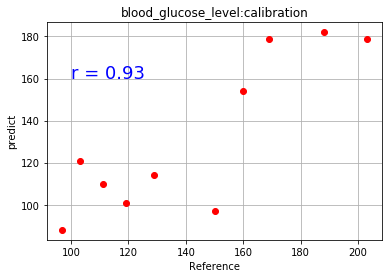

In [32]:
plt.plot(tarr_ref, tarr_pre, 'ro')
plt.grid()
plt.xlabel('Reference')
plt.ylabel('predict')
plt.title('blood_glucose_level:calibration')
plt.text(100,160, 'r = 0.93', fontsize=18, color='b')
plt.savefig('val_result')
plt.show()

## 8.2 Varidation of test data

In [36]:
# 検証（テストデータ）
# test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("%d, %d " % (ref, pred))


131, 140 
122, 112 
126, 128 
134, 128 
129, 121 


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
# arr_train = numpy.array([97, 222, 109, 165, 205, 172, 167, 142, 160, 103])
arr_test = numpy.array([100, 187, 115, 184, 164, 193, 148, 151, 153, 102])

cor = numpy.corrcoef(arr_train, arr_test)[0, 1]
print(cor)

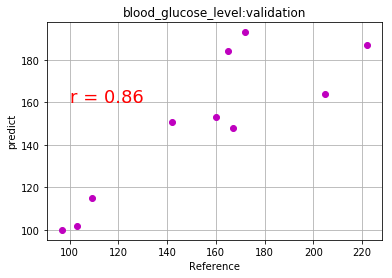

In [35]:
plt.plot(arr_train, arr_test, 'mo')
plt.grid()
plt.xlabel('Reference')
plt.ylabel('predict')
plt.title('blood_glucose_level:validation')
plt.text(100,160, 'r = 0.86', fontsize=18, color='r')
plt.savefig('val_result')
plt.show()